In [1]:
from scipy import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.cluster import KMeans
from scipy import linalg
from scipy.misc import logsumexp
from matplotlib.patches import Ellipse
from sklearn import mixture


In [2]:
class GMM:
    def __init__(self, n_components, initial_weights, initial_means, initial_sigmas):
        self.n_components = n_components
        self.means = initial_means
        self.weights = initial_weights
        self.sigmas = initial_sigmas


In [3]:
# Esto da el valor mínimo para un float sin ser 0
eps = np.finfo(float).eps
# Valor para terminar la iteración
threshold = 0.001

In [4]:
def log_multivariable_normal(X, mean, sigma, n_components):
    x = X.T
    # Evitar problemas de dimensiones
    sigma = np.atleast_2d(sigma)

    lhs = -(n_components / 2) * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(sigma))
    rhs = -0.5 * (x.T - mean).T * np.dot(linalg.inv(sigma), (x.T - mean).T)
    if rhs.ndim == 2:
        rhs = np.sum(rhs, axis=0)
    return lhs + rhs

In [5]:
# Calculado según ecuaciones de https://www.cs.ubc.ca/~murphyk/Papers/learncg.pdf
def calculate_new_sigmas(X, gammas, means, n_components):
    num_dims = X.shape[1]
    # Nuevo arreglo de sigmas
    sigmas = np.empty((n_components, num_dims, num_dims))
    for k in range(n_components):
        post_resps = gammas[:, k]
        mean = means[k]
        diff = X - mean
        # El último factor se agrega para evitar indeterminación
        avg_sigma = np.dot(post_resps * diff.T, diff) / (post_resps.sum() + 10 * eps)
        sigmas[k] = avg_sigma
    return sigmas

In [6]:
def e_step(gmm, X):
    probs_mat = np.zeros((X.shape[0], gmm.n_components))
    # Calculamos las responsabilidades
    for i in range(gmm.n_components):
        probs_mat[:, i] = log_multivariable_normal(X, gmm.means[i], gmm.sigmas[i], gmm.n_components) + \
                          np.log(gmm.weights[i])

    lpr = logsumexp(probs_mat, axis=1)
    gammas = np.exp(probs_mat - lpr[:, np.newaxis])
    return lpr, gammas

In [7]:
def m_step(gmm, X, gammas):
    # Los nuevos pesos son las sumas de las responsabilidades ponderado por la suma de todos los componentes
    weights = gammas.sum(axis=0)
    # Al actualizar, agregamos un mínimo para evitar valores indeterminados
    gmm.weights = (weights / (weights.sum() + 10 * eps) + eps)

    weighted_gammas = np.dot(gammas.T, X)
    # Nuevamente evitamos valores indeterminados
    inverse_weights = 1.0 / (weights[:, np.newaxis] + 10 * eps)

    gmm.means = weighted_gammas * inverse_weights
    gmm.sigmas = calculate_new_sigmas(X, gammas, gmm.means, gmm.n_components)


In [8]:
def plot_2d(X, means, sigmas, fig_number, title):
    fig = plt.figure(fig_number)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.scatter(X[:, 0], X[:, 1], c='yellow')
    ax.scatter(means[:, 0], means[:, 1], s=40)
    for idx, mean in enumerate(means):
        covar_matrix = sigmas[idx]
        w, v = np.linalg.eig(covar_matrix)
        width = 2 * np.sqrt(w[0] * 5.991)
        height = 2 * np.sqrt(w[1] * 5.991)
        largest_vector = v[0]
        if np.linalg.norm(v[1]) > np.linalg.norm(v[0]):
            largest_vector = v[1]
        v1_y = largest_vector[1]
        v1_x = largest_vector[0]
        angle = np.arctan(v1_x / v1_y) * 180 / np.pi
        e = Ellipse(mean, width=height, height=width, angle=angle)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.6)
        e.set_facecolor(random.rand(3))
        ax.add_artist(e)
        plt.title(title)


In [9]:
def fit_gmm(X, n_components):
    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(X)
    # Primero, inicializamos ocupando k-means
    means = kmeans.cluster_centers_
    # Pesos aleatorios uniformes
    weights = np.tile(1.0 / n_components, n_components)
    predictions = kmeans.predict(X)

    # Para las covarianzas inicializamos con covarianza intra-clusters
    covs = []
    for cluster in range(n_components):
        cluster_data = X[predictions == cluster]
        covs.append(np.cov(cluster_data.T))
    covs = np.array(covs)
    weights = np.array(weights)
    mixture = GMM(n_components, weights, means, covs)
    lpr = np.finfo(float).min
    
    num_iters = 100
    # Max 100 iteraciones
    for i in range(num_iters):
        logs, gammas = e_step(mixture, X)
        m_step(mixture, X, gammas)
        mean_logs = logs.mean()
        # int('Delta for iteration ' + str(i) + ': ' + str(np.abs(mean_logs - lpr)))
        if np.abs(mean_logs - lpr) < threshold:
            num_iters = (i + 1)
            break

        lpr = mean_logs
        
    print('delta after ' + str(num_iters) + ' iterations: ' + str(lpr - mean_logs))
    # Ploteamos 2D para visualizar resultados
    if X.shape[1] == 2:       
        plot_2d(X, mixture.means, mixture.sigmas, 0, 'Calculado')

    print('Calculated means: ')
    print(np.sort(mixture.means, axis=0))
    # print('Calculated covars: ')
    # print(mixture.sigmas)
    # print('Calculated weights: ')
    # print(mixture.weights)
    gmm = sklearn.mixture.GaussianMixture(n_components, verbose=0, tol=threshold)
    gmm.fit(X)
    print('Sklearn means: ')
    print(np.sort(gmm.means_, axis=0))
    # print('Sklearn covars: ')
    # print(gmm.covariances_)
    # print('Sklearn weights: ')
    # print(gmm.weights_)

    if X.shape[1] == 2:
        plot_2d(X, gmm.means_, gmm.covariances_, 1, 'Sklearn')
        print('--------------')
        print('Plotting 2D cases')
        print('--------------')
        plt.show()
        

In [10]:
# Generamos los datos con normal multivariable
def generate_data(num_dims, n_components):
    X = np.empty([0, num_dims])
    all_means = []
    for i in range(n_components):
        # Con esto aseguramos de generar matriz positiva semi definida
        cov = random.rand(num_dims, num_dims)
        cov = np.dot(cov, cov.transpose())
        means = []
        for j in range(num_dims):
            # Medias aleatorias
            means.append(random.uniform(-5, 5))
        new_data = np.random.multivariate_normal(means, cov, random.randint(100, 400))
        X = np.concatenate((X, new_data))
        all_means.append(means)
    return X

------------------------------
Results for 2 dimensions - 7 components
------------------------------
delta after 17 iterations: -0.000458445791668
Calculated means: 
[[-3.43515304 -4.12098789]
 [-2.98442308 -3.61850924]
 [-1.96400427 -3.21697637]
 [-1.92177538  1.37590641]
 [ 1.98635554  2.96922423]
 [ 3.04942405  3.15260128]
 [ 3.66665246  4.10136532]]
Sklearn means: 
[[-3.43070117 -4.12098789]
 [-2.96850644 -3.61841272]
 [-1.96351017 -3.21723388]
 [-1.92206709  1.3759235 ]
 [ 1.98635554  2.96934008]
 [ 3.049437    3.16214892]
 [ 3.66668741  4.1345977 ]]
--------------
Plotting 2D cases
--------------


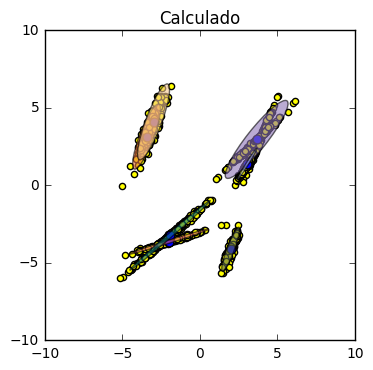

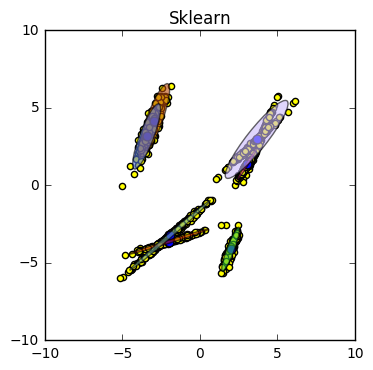

------------------------------
Results for 3 dimensions - 5 components
------------------------------
delta after 5 iterations: -0.000612678037728
Calculated means: 
[[-5.02696439 -3.25339091 -3.28119291]
 [-1.11435587 -0.79598768 -0.95658314]
 [-0.19467952  0.43216261  0.67641706]
 [ 3.12895366  1.2401038   0.88334197]
 [ 4.40821275  1.97936245  3.54436571]]
Sklearn means: 
[[-5.02696439 -3.25339091 -2.21496414]
 [-0.61650747 -0.79598768  0.16214718]
 [ 3.12895366  0.55341222  0.88334197]
 [ 4.2009152   1.14181676  1.22557823]
 [ 4.62957468  1.97338484  3.54436571]]


In [11]:
random_params = [(2, 7), (3, 5)]
plt.close("all")

for params in random_params:
    print('------------------------------')
    print('Results for ' + str(params[0]) + " dimensions - " + str(params[1]) + " components")
    print('------------------------------')
    X = generate_data(params[0], params[1])
    fit_gmm(X, params[1])